In [6]:
!pip install streamlit requests numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [5]:
!pip install pyngrok


2024-08-12 17:28:55.491 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-08-12 17:28:55.497 Session state does not function when running a script without `streamlit run`


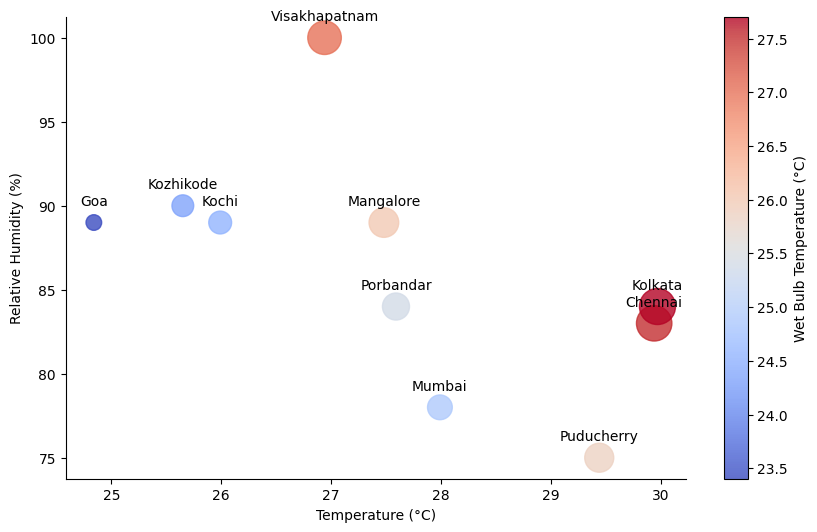

In [7]:
import streamlit as st
import requests
import numpy as np
import matplotlib.pyplot as plt

API_KEY = "ee4a54840d7fc3dcee7ef40695cb437c"
OPENWEATHERMAP_URL = "http://api.openweathermap.org/data/2.5/weather"

def get_weather_data(city_name):
    url = f"{OPENWEATHERMAP_URL}?q={city_name}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    data = response.json()
    if response.status_code == 200:
        temp = data['main']['temp']
        humidity = data['main']['humidity']
        return temp, humidity
    else:
        st.error(f"Error fetching weather data for {city_name}: {data['message']}")
        return None, None

def calculate_wet_bulb_temperature(temp, humidity):
    tw = temp * np.arctan(0.152 * (humidity + 8.3136)**(1/2)) + np.arctan(temp + humidity) - np.arctan(humidity - 1.6763) + 0.00391838 * humidity**(3/2) * np.arctan(0.0231 * humidity) - 4.686
    return tw

def plot_graph(city_names, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    wet_bulb_temps = []
    temperatures = []
    humidities = []
    high_wet_bulb_cities = []

    for city_name in city_names:
        temp, humidity = get_weather_data(city_name)
        if temp is not None and humidity is not None:
            wet_bulb_temp = calculate_wet_bulb_temperature(temp, humidity)
            wet_bulb_temps.append(wet_bulb_temp)
            temperatures.append(temp)
            humidities.append(humidity)
            if wet_bulb_temp > 32:
                high_wet_bulb_cities.append((city_name, wet_bulb_temp))

    min_wet_bulb_temp = min(wet_bulb_temps) - 1
    max_wet_bulb_temp = max(wet_bulb_temps) + 1
    normalized_wet_bulb_temps = [(temp - min_wet_bulb_temp) / (max_wet_bulb_temp - min_wet_bulb_temp) for temp in wet_bulb_temps]

    ax.clear()
    scatter = ax.scatter(temperatures, humidities, s=np.array(normalized_wet_bulb_temps)*800, c=wet_bulb_temps, cmap='coolwarm', alpha=0.8)
    plt.colorbar(scatter, label='Wet Bulb Temperature (°C)')

    for i, txt in enumerate(city_names):
        ax.annotate(txt, (temperatures[i], humidities[i] + 0.2), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Relative Humidity (%)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return fig, ax, high_wet_bulb_cities, wet_bulb_temps

def main():
    st.set_page_config(layout="wide")

    coastal_cities = [
        "Mumbai",
        "Chennai",
        "Kolkata",
        "Kochi",
        "Visakhapatnam",
        "Goa",
        "Mangalore",
        "Puducherry",
        "Kozhikode",
        "Porbandar"
    ]
    city_names = coastal_cities

    col1, col2, col3 = st.columns([2, 4, 2])

    with col2:
        st.title('Wet Bulb Temperature vs Temperature vs Humidity')
        st.markdown('##### Along the Coastal Cities of India')
        add_city = st.text_input('Add City')
        remove_city = st.text_input('Remove City')
        refresh_graph = st.button('Refresh Graph')

        fig, ax = None, None
        high_wet_bulb_cities = []
        wet_bulb_temps = []

        if refresh_graph:
            fig, ax, high_wet_bulb_cities, wet_bulb_temps = plot_graph(coastal_cities)
            city_names = coastal_cities
        else:
            fig, ax, high_wet_bulb_cities, wet_bulb_temps = plot_graph(city_names, fig, ax)

        if add_city:
            if add_city not in city_names:
                temp, humidity = get_weather_data(add_city)
                if temp is not None and humidity is not None:
                    city_names.append(add_city)
                    st.success(f"Added {add_city} to the graph!")
                    fig, ax, high_wet_bulb_cities, wet_bulb_temps = plot_graph(city_names)
                else:
                    st.error(f"Failed to fetch weather data for {add_city}. Try again.")
            else:
                st.warning(f"{add_city} is already in the graph.")

        if remove_city:
            if remove_city in city_names:
                city_names.remove(remove_city)
                st.info(f"Removed {remove_city} from the graph.")
                fig, ax, high_wet_bulb_cities, wet_bulb_temps = plot_graph(city_names)
            else:
                st.warning(f"{remove_city} is not in the graph.")

        st.pyplot(fig)

    with col1:
        st.header("About")
        st.markdown("""
    This app visualizes wet bulb temperature, temperature, and humidity of coastal cities in India.
    Wet bulb temperature is the lowest temperature air can reach via water evaporation,
    crucial for assessing heat stress and humidity.

    ***Key thresholds:***
    - **35°C:** Without cooling and hydration, it can be fatal within 6 hours.
    - **32°C:** Significant discomfort, emphasizes sun avoidance and hydration to manage heat risks.

    Understanding these thresholds is vital for individual well-being, especially in hot, humid climates.
""")

    with col3:
        if high_wet_bulb_cities:
            st.markdown("### Cities with Wet Bulb Temperature > 32°C")
            for city, wet_bulb_temp in high_wet_bulb_cities:
                st.markdown(f"- **{city}**: {wet_bulb_temp:.2f}°C")
        else:
            st.success("#### 😌🌿 All cities are within the threshold of 32°C wet bulb temperature")
            sorted_cities = sorted(zip(city_names, wet_bulb_temps), key=lambda x: x[1], reverse=True)
            top_three_cities = sorted_cities[:3]
            st.markdown("##### Top three cities with highest Wet Bulb Temperature 🥵")
            for city, wet_bulb_temp in top_three_cities:
                st.markdown(f"- **{city}**: {wet_bulb_temp:.2f}°C")

        st.markdown("Weather data provided by [OpenWeatherMap](https://openweathermap.org/).")

if __name__ == "__main__":
    main()